In [7]:
import numpy as np
import pandas as pd
import os
import ast
import matplotlib.pyplot as plt
import pickle

df_road = pd.read_csv('../database/data/road.csv')
df_rel = pd.read_csv("../database/data/rel.csv")

num_road = df_road['id'].count()
num_rel = df_rel['id'].count()

原始特征编码方法：
+ highway type, 独热码，如果这一项缺失，就干脆全都是0.. （这样是13维）
+ degree embedding, 节点度的embedding编码，用(sin 2^0d, sin 2^1d, sin 2^2d...), 暂定弄到8维.
+ density embedding, 道路空间密度，为了方便计算，预定义一些小格，把路段分到这些小格中，用每个小格中有的路段数量除以小格面积当作这个小格中路段的近似密度；路段只以起点和终点计入网格中，如果起点和中点在两个不同的格，就同时记入两个网格中，其密度用两个网格密度的平均. 同样也用正弦或者余弦嵌入编码一下，暂定弄到8维. 算上degree和density的原始数据，这样一共就是31维.

先试一下看看效果.

In [8]:
# 网格范围.
west_bound = 1000
east_bound = 0
north_bound = 0
south_bound = 1000
for idx, road in df_road.iterrows():
    coord = ast.literal_eval(road[1])
    for point in coord:
        if point[0] < west_bound:
            west_bound = point[0]
        if point[0] > east_bound:
            east_bound = point[0]
        if point[1] < south_bound:
            south_bound = point[1]
        if point[1] > north_bound:
            north_bound = point[1]
print("north: {}, south: {}, west: {}, east: {}".format(north_bound, south_bound, west_bound, east_bound))

C:\Users\admin\AppData\Local\Temp\ipykernel_5404\3590916984.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coord = ast.literal_eval(road[1])


north: 40.0006224, south: 39.7955236, west: 116.2500662, east: 116.5018476


0.007193754285714249 0.007324957142856954


C:\Users\admin\AppData\Local\Temp\ipykernel_5404\1796705185.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coord = ast.literal_eval(road[1])


383.0 3.0


(array([2651., 7555., 8760., 7909., 4866., 3594.,  794., 1054.,  177.,
         667.]),
 array([  3.,  41.,  79., 117., 155., 193., 231., 269., 307., 345., 383.]),
 <BarContainer object of 10 artists>)

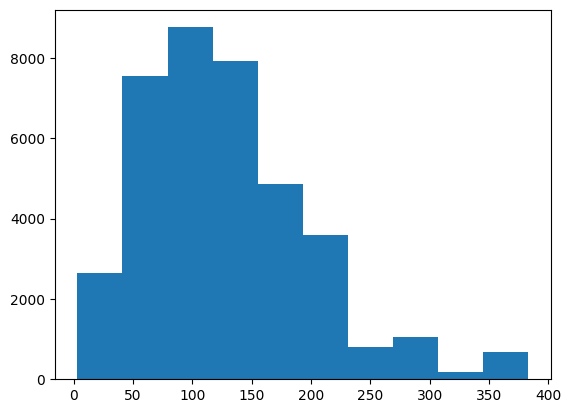

In [9]:
grid_x = 35   # 东西向
grid_y = 28   # 大概1度600米范围..
grid_x_range = (east_bound - west_bound) / grid_x
grid_y_range = (north_bound - south_bound) / grid_y
print(grid_x_range, grid_y_range)
grid = np.zeros((grid_x, grid_y))
road_in = np.zeros((num_road, 2))
road_intensity = np.zeros((num_road))
for idx, road in df_road.iterrows():
    coord = ast.literal_eval(road[1])
    for i in [0, -1]:  # 起点终点
        point = coord[i]
        x_val = int(np.floor((point[0] - west_bound) / grid_x_range))
        y_val = int(np.floor((point[1] - south_bound)/ grid_y_range))
        grid[x_val, y_val] += 1
        road_in[idx,i] = x_val * grid_x + y_val
for idx in range(num_road):
    start_block = road_in[idx,0]
    end_block = road_in[idx, 1]
    start_num = grid[int(start_block//grid_x), int(start_block%grid_x)]
    end_num = grid[int(end_block//grid_x), int(end_block%grid_x)]
    average_num = (start_num + end_num) / 2
    road_intensity[idx] = average_num   # 这里的单位面积大约是600m*600m.

print(road_intensity.max(), road_intensity.min())
plt.hist(road_intensity)

C:\Users\admin\AppData\Local\Temp\ipykernel_5404\1280357664.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  origin_id = int(rel[1])
C:\Users\admin\AppData\Local\Temp\ipykernel_5404\1280357664.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  target_id = int(rel[2])


0.0 11.0


(array([4.8000e+01, 2.4220e+03, 3.2640e+03, 8.4190e+03, 6.1870e+03,
        1.2723e+04, 4.0640e+03, 8.7000e+02, 2.0000e+01, 1.0000e+01]),
 array([ 0. ,  1.1,  2.2,  3.3,  4.4,  5.5,  6.6,  7.7,  8.8,  9.9, 11. ]),
 <BarContainer object of 10 artists>)

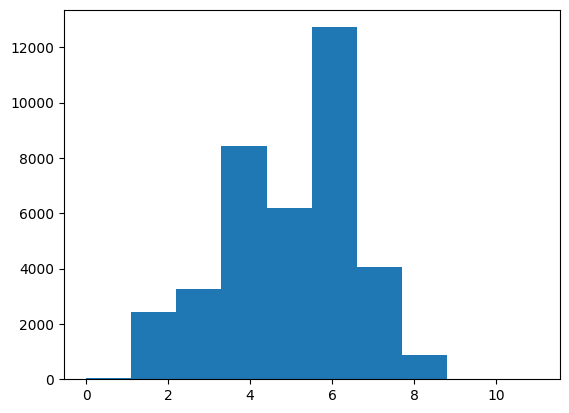

In [10]:
# 计算度，degree.
degree = np.zeros((num_road))
for idx, rel in df_rel.iterrows():
    origin_id = int(rel[1])
    target_id = int(rel[2])
    degree[origin_id] += 1
    degree[target_id] += 1
print(degree.min(), degree.max())
plt.hist(degree)

In [13]:
# 这回加上路段长度，放在最后.

degree_dim = 8
intensity_dim = 8
num_highway = 13
n_features = num_highway + 1 + degree_dim + 1 + intensity_dim

highway_code = np.zeros((num_road, num_highway))
for idx, road in df_road.iterrows():
    highway = int(road[2])
    if highway != 0:
        highway_code[idx, highway-1] = 1

degree_embd = np.zeros((num_road, degree_dim))
first = True
for i in range(degree_dim):
    if first:
        tmp = degree
        first = False
    else:
        tmp = 2 * tmp
    degree_embd[:, i] = np.sin(tmp)

intensity_embd = np.zeros((num_road, intensity_dim))
first = True
for i in range(intensity_dim):
    if first:
        tmp = road_intensity
        first = False
    else:
        tmp = 2 * tmp
    intensity_embd[:,i] = np.sin(tmp)

# 获取路段长度.
lengths = np.array(list(map(lambda x:float(x), df_road['length'])))

# road_features = np.float32(np.concatenate((highway_code, degree[:,np.newaxis], degree_embd, road_intensity[:,np.newaxis], intensity_embd), axis=1))
road_features = np.float32(np.concatenate((highway_code, degree[:,np.newaxis], degree_embd, road_intensity[:,np.newaxis], intensity_embd, lengths[:,np.newaxis]), axis=1))
print(road_features.shape)
# with open("road_features.pkl", "wb") as f:
#     pickle.dump(road_features, f)
with open("road_features_with_lengths.pkl", "wb") as f:
    pickle.dump(road_features, f)

C:\Users\admin\AppData\Local\Temp\ipykernel_5404\2406394669.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  highway = int(road[2])


(38027, 32)


下面预处理traj. 取出有效的traj, 其轨迹的路段编号数组(opath)，其起点和终点的坐标(注意是匹配后的点.)，其起点和终点的速度... (先不求每个路段上的平均速度来做约束了,...看看效果先.)
它将作为数据集使用.
注意，这里导出的轨迹信息将作为数据集使用，其id和原本的traj_id并不对应(没有考虑跳过的情况.), 但是有一个单独的traj_id的域.

数据集中每一项是一个元组：  
**( traj_id, 起始点在路径上对应的匹配点的位置，终点在路径上对应的匹配点的位置，起始点的速度，终点的速度，轨迹总时间(in minutes)，路径中每个路段的id )**

In [ ]:
# cpath: 需要的路径(编号.). opath, 每个点匹配到的路段的编号.
df_traj_raw = pd.read_csv("../database/data/traj.csv")
df_traj = pd.read_csv("../database/fmm/fmm_all_fields.csv", delimiter=";")


def ComputeDuration(start_time:str, end_time:str):
    '''
    给出轨迹的起始时间和结束时间，计算这条轨迹花了多长时间.
    时间字符串格式："yyyy-mm-ddTHH:MM:SSZ"
    返回分钟. 观察到全是2013年10月的，所以不用管年份和月份.
    '''
    dd = (int(end_time[8:10]) - int(start_time[8:10])) * 1440
    dh = (int(end_time[11:13]) - int(start_time[11:13])) * 60
    dm = (int(end_time[14:16]) - int(start_time[14:16]))
    ds = (int(end_time[-3:-1]) - int(start_time[-3:-1])) / 60
    return dd + dh + dm + ds


# 每个轨迹的起点和终点速度.
speed_duration = {}  # tid->speeds, ndarray, 0:start_time, 1:end_time, 2:duration.
traj_id = -1
speeds = np.zeros((2))

for idx, raw_traj in df_traj_raw.iterrows():
    tid = raw_traj['traj_id']
    speed = raw_traj['speeds']
    if traj_id != tid:
        if traj_id != -1:
            duration = np.array([ComputeDuration(start_time, end_time)])
            speed_duration[traj_id] = np.concatenate((speeds, duration))
        traj_id = tid
        speeds = np.array([speed, speed])
        start_time = end_time = raw_traj['time']
    else:
        speeds[1] = speed
        end_time = raw_traj['time']
duration = np.array([ComputeDuration(start_time, end_time)])
speed_duration[traj_id] = np.concatenate((speeds, duration))

def ParseLineString(linestring:str, idx:list = None):
    '''
    按照idx列表中指定的索引返回一个数组，里面每个元素是代表一个点的长度为2的list，idx为None则按顺序返回所有点形成的list.
    '''
    nums_str = linestring[11:-1]
    points_str = nums_str.split(',')
    if idx is None:
        ret = map(lambda s: ast.literal_eval('[{}]'.format(s.replace(' ', ',', 1))), points_str)
    ret = [ast.literal_eval('[{}]'.format(points_str[i].replace(' ', ',', 1))) for i in idx]
    return ret


total_traj_num = df_traj['id'].count()
valid = 0
traj_data = []
for idx, traj in df_traj.iterrows():
    tid = traj['id']
    try:
        road_path_ids = ast.literal_eval('[{}]'.format(traj['cpath']))
    except:
        continue   # [nan]，没有数据，没有匹配成功
    if len(road_path_ids) == 0:
        continue
    start_end_matched_points = ParseLineString(traj['pgeom'], [0, -1])
    speeds = speed_duration[tid]
    entry = (tid, start_end_matched_points[0], start_end_matched_points[1], speeds[0], speeds[1], speeds[2], road_path_ids)
    traj_data.append(entry)
    valid += 1

#traj_data.sort(key=lambda x: x[0])
print(traj_data)
print("{} trajs in total, {} is successfully matched.".format(total_traj_num, valid))
with open("traj_data.pkl", "wb") as f:
    pickle.dump(traj_data, f)

In [6]:
with open("traj_data.pkl", "rb") as f:
    traj_data = pickle.load(f)
print(len(traj_data))

16967


In [12]:
# 形成时间，与是否是holiday..
import numpy as np
import pandas as pd
import ast
import pickle

df_traj_raw = pd.read_csv("../database/data/traj.csv")
df_traj = pd.read_csv("../database/fmm/fmm_all_fields.csv", delimiter=";")
hour_holiday = {}  # tid->[hour, holiday(0,1)]
traj_id = -1
speeds = np.zeros((2))

for idx, raw_traj in df_traj_raw.iterrows():
    tid = raw_traj['traj_id']
    hour = int(raw_traj['time'][11:13])
    holiday = int(raw_traj['holidays'])
    if traj_id != tid:
        if traj_id != -1:
            hour_holiday[traj_id] = np.array([hour, holiday], dtype=np.float32)
        traj_id = tid

hour_holiday[traj_id] = np.array([hour, holiday], dtype=np.float32)

total_traj_num = df_traj['id'].count()
valid = 0
traj_hour_holiday = []
for idx, traj in df_traj.iterrows():
    tid = traj['id']
    try:
        road_path_ids = ast.literal_eval('[{}]'.format(traj['cpath']))
    except:
        continue   # [nan]，没有数据，没有匹配成功
    if len(road_path_ids) == 0:
        continue
    h_and_holiday = hour_holiday[tid]
    traj_hour_holiday.append(h_and_holiday)
    valid += 1
print(valid)
traj_hour_holiday = np.array(traj_hour_holiday, dtype=np.float32)
print(traj_hour_holiday)
with open("traj_hour_holiday.pkl", "wb") as f:
    pickle.dump(traj_hour_holiday, f)

16967
[[14.  0.]
 [20.  1.]
 [20.  0.]
 ...
 [11.  0.]
 [12.  0.]
 [12.  0.]]


In [4]:
import pickle
import numpy as np

with open("traj_data.pkl", "rb") as f:
    traj_data = pickle.load(f)

train_rate = 0.4
eval_rate = 0.3
test_rate = 0.3

n_train = int(len(traj_data) * train_rate)
n_eval = int(len(traj_data) * eval_rate)
n_test = len(traj_data) - n_train - n_eval

print("total: {}\ntrain: {}\neval: {}\ntest: {}".format(len(traj_data), n_train, n_eval, n_test))

np.random.shuffle(traj_data)

traj_data_sets = {
    'traj_data_train':traj_data[:n_train],
    'traj_data_eval':traj_data[n_train:n_train+n_eval],
    'traj_data_test':traj_data[n_train+n_eval:],
}

for n in ['traj_data_train', 'traj_data_eval', 'traj_data_test']:
    with open(n+'.pkl', "wb") as f:
        pickle.dump(traj_data_sets[n], f)

total: 16967
train: 6786
eval: 5090
test: 5091


In [13]:
# 保存hour_holidays
with open("traj_hour_holiday.pkl", "rb") as f:
    traj_hour_holiday = pickle.load(f)

train_rate = 0.4
eval_rate = 0.3
test_rate = 0.3

n_train = int(len(traj_hour_holiday) * train_rate)
n_eval = int(len(traj_hour_holiday) * eval_rate)
n_test = len(traj_hour_holiday) - n_train - n_eval

print("total: {}\ntrain: {}\neval: {}\ntest: {}".format(len(traj_hour_holiday), n_train, n_eval, n_test))

np.random.shuffle(traj_hour_holiday)

traj_data_sets = {
    'traj_hour_holiday_train':traj_hour_holiday[:n_train],
    'traj_hour_holiday_eval':traj_hour_holiday[n_train:n_train+n_eval],
    'traj_hour_holiday_test':traj_hour_holiday[n_train+n_eval:],
}

for n, d in traj_data_sets.items():
    with open(n+'.pkl', "wb") as f:
        pickle.dump(d, f)

total: 16967
train: 6786
eval: 5090
test: 5091


In [17]:
import numpy as np
import pickle

with open("road_features_with_lengths.pkl", "rb") as f:
    feat = pickle.load(f)

print(feat[5])

[ 0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  1.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  6.0000000e+00 -2.7941549e-01 -5.3657293e-01
 -9.0557837e-01 -7.6825464e-01  9.8358774e-01 -3.5493836e-01
  6.6365641e-01  9.9287981e-01  1.2700000e+02  9.7263008e-01
  4.5199889e-01 -8.0638278e-01 -9.5377982e-01  5.7323366e-01
 -9.3940610e-01 -6.4406866e-01  9.8538345e-01  5.3991302e+02]


(5501, [116.375684953, 39.9902666619], [116.351099354, 39.999835244], 37.78, 40.1875, 5.0, [5899, 5897, 5895, 21359, 2549, 5909, 26137, 26150, 26138, 5908, 29227, 26152, 4213, 26456, 21320, 21319, 28627, 23593, 21369, 21356, 21355, 21352, 2545, 1228, 29252, 1224, 17144, 6024, 17874, 19637, 17857, 17860, 25410, 25413])
[2.1333333333333333, 5.0, 5.366666666666666, 2.6333333333333333, 6.2, 12.983333333333333, 5.0, 19.333333333333332, 6.416666666666667, 9.416666666666666, 17.183333333333334, 10.266666666666667, 14.616666666666667, 3.066666666666667, 29.183333333333334, 2.3666666666666667, 11.316666666666666, 9.733333333333333, 18.1, 9.983333333333333, 4.183333333333334, 20.9, 9.416666666666666, 10.883333333333333, 5.333333333333333, 23.833333333333332, 14.25, 12.166666666666666, 31.683333333333334, 6.833333333333333, 25.6, 11.083333333333334, 10.833333333333334, 34.833333333333336, 14.3, 2.0833333333333335, 4.2, 11.55, 21.25, 25.85, 5.55, 55.85, 7.716666666666667, 26.083333333333332, 4.95,

(array([8162., 4803., 2117.,  898.,  503.,  234.,  109.,   75.,   43.,
          23.]),
 array([  2.        ,  13.73666667,  25.47333333,  37.21      ,
         48.94666667,  60.68333333,  72.42      ,  84.15666667,
         95.89333333, 107.63      , 119.36666667]),
 <BarContainer object of 10 artists>)

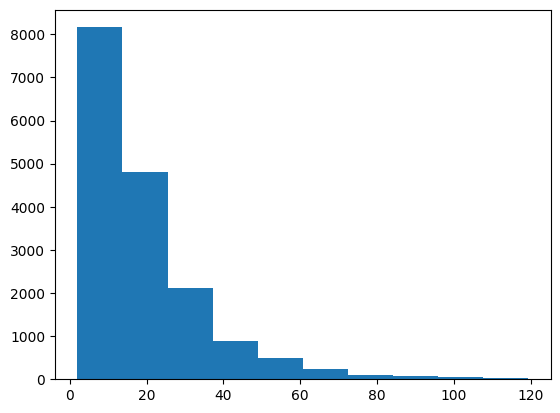

In [6]:
import numpy as np
import pickle
import matplotlib.pyplot as plt

with open("traj_data.pkl", "rb") as f:
    traj = pickle.load(f)

print(traj[1])

times = list(map(lambda x: x[-2], traj))
print(times)
plt.hist(times)

In [12]:
import numpy as np
import pickle
import matplotlib.pyplot as plt

with open("./GRUBoosting/layer1.weight", "rb") as f:
    w = pickle.load(f) * 6786
print(w, w.min(), w.max(), w.mean(), np.sum(w))

with open("./GRUBoosting/alphas.alpha", "rb") as f:
    a = pickle.load(f)
print(a)

[3.7519862e-10 3.0983499e-10 3.3209002e-10 ... 3.2754355e-10 3.0941325e-10
 3.0977315e-10] 3.076861e-10 6786.0 1.0 6786.0
[0.0370302]
